# Example 10: Full workflow with MTpy-v2 as the Driver

This example contains the full workflow
1. Request data from IRIS to make an MTH5
2. Compute a transfer function using Aurora
3. Adding the transfer function to MHT5
4. Visualize using MTpy

**Note:** this example assumes that data availability (Network, Station, Channel, Start, End) are all previously known.  If you do not know the data that you want to download use [IRIS tools](https://ds.iris.edu/ds/nodes/dmc/tools/##) to get data availability.   

## 1. Create MTH5 from IRIS

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from mth5.mth5 import MTH5
from mth5.clients.make_mth5 import MakeMTH5

from matplotlib import pyplot as plt
%matplotlib inline

### Set the path to save files to as the current working directory

In [3]:
default_path = Path().cwd()
print(default_path)

/home/jovyan/earthscope-mt-course/notebooks/mth5


### Make the data inquiry as a DataFrame

There are a few ways to make the inquiry to request data.  

1. Make a DataFrame by hand.  Here we will make a list of entries and then create a DataFrame with the proper column names
2. You can create a CSV file with a row for each entry. There are some formatting that you need to be aware of.  That is the column names and making sure that date-times are YYYY-MM-DDThh:mm:ss


| Column Name         |   Description                                                                                                 |
| ------------------- | --------------------------------------------------------------------------------------------------------------|
| **network**         | [FDSN Network code (2 letters)](http://www.fdsn.org/networks/)                                                |
| **station**         | [FDSN Station code (usually 5 characters)](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)|
| **location**        | [FDSN Location code (typically not used for MT)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/location-codes.html) |
| **channel**         | [FDSN Channel code (3 characters)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/channel-codes.html)|
| **start**           | Start time (YYYY-MM-DDThh:mm:ss) UTC |
| **end**             | End time (YYYY-MM-DDThh:mm:ss) UTC  |

To create the request you can use any of the [IRIS Data Services tools](https://ds.iris.edu/ds/nodes/dmc/tools/##), a nice map view request [GMAP](http://ds.iris.edu/gmap/).  Be sure to identify 2 stations that recorded at the same time for at least a week.  Network codes for MT that have correct metadata are `ZU` and `8P`, other network codes like `EM` still need work on making sure calibrations are correct.


In [9]:
channels = ["LFE", "LFN", "LFZ", "LQE", "LQN"]
 
WYYS2 = ["4P", "WYYS2", "2009-07-15T00:00:00", "2009-08-21T00:00:00"]
MTF20 = ["4P", "MTF20", "2009-07-03T00:00:00", "2009-08-13T00:00:00"]

request_list = []
for entry in [WYYS2, MTF20]:
    for channel in channels:
        request_list.append(
            [entry[0], entry[1], "", channel, entry[2], entry[3]]
        )

# Turn list into dataframe
request_df = pd.DataFrame(
    request_list,
    columns=[
            "network",
            "station",
            "location",
            "channel",
            "start",
            "end",
        ]
) 
request_df.to_csv(default_path.joinpath("fdsn_request.csv"))
request_df

,network,station,location,channel,start,end
0,4P,WYYS2,,LFE,2009-07-15T00:00:00,2009-08-21T00:00:00
1,4P,WYYS2,,LFN,2009-07-15T00:00:00,2009-08-21T00:00:00
2,4P,WYYS2,,LFZ,2009-07-15T00:00:00,2009-08-21T00:00:00
3,4P,WYYS2,,LQE,2009-07-15T00:00:00,2009-08-21T00:00:00
4,4P,WYYS2,,LQN,2009-07-15T00:00:00,2009-08-21T00:00:00
5,4P,MTF20,,LFE,2009-07-03T00:00:00,2009-08-13T00:00:00
6,4P,MTF20,,LFN,2009-07-03T00:00:00,2009-08-13T00:00:00
7,4P,MTF20,,LFZ,2009-07-03T00:00:00,2009-08-13T00:00:00
8,4P,MTF20,,LQE,2009-07-03T00:00:00,2009-08-13T00:00:00
9,4P,MTF20,,LQN,2009-07-03T00:00:00,2009-08-13T00:00:00


### Make an MTH5

Now that we've created a request, and made sure that its what we expect, we can make an MTH5 file.  The input can be either the DataFrame or the CSV file.  We are going to time it just to get an indication how long it might take.  Should take about 4 minutes.

**Note:** we are setting `interact=False`.  If you want to just to keep the file open to interogat it set `interact=True`. 

In [10]:
%%time

mth5_path = MakeMTH5.from_fdsn_client(request_df, interact=False)

print(f"Created {mth5_path}")

2024-10-17T12:04:04.365443-0700 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file /home/jovyan/earthscope-mt-course/notebooks/mth5/4P_WYYS2_MTF20.h5 in mode w
2024-10-17T12:04:34.947556-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2024-10-17T12:04:34.963637-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_100.000 to a CoefficientFilter.
2024-10-17T12:04:35.050756-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2024-10-17T12:04:35.066423-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_100.000 to a CoefficientFilter.
2024-10-17T12:04:35.422952-0700 | INFO | mt_metadat

NameError: name 'mth5_object' is not defined

#### If you are rerunning processing

In [2]:
mth5_path = Path("EM_WYYS2_MTF20.h5")

## 2. Estimate Transfer Function

Now that an MTH5 has been created we can estimate a transfer function using Aurora.  

In [11]:
import warnings

from mtpy.processing import AuroraProcessing

warnings.filterwarnings('ignore')

### Get a Run Summary
Get a run summary from the create mth5. We are going to provide the path to `RunSummary`.     

In [12]:
ap = AuroraProcessing()
ap.local_station_id = "WYYS2"
ap.local_mth5_path = mth5_path

ap.remote_station_id = "MTF20"
ap.remote_mth5_path = mth5_path


In [13]:
run_summary = ap.get_run_summary()
run_summary.mini_summary

2024-10-17T12:11:51.700166-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/jovyan/earthscope-mt-course/notebooks/mth5/4P_WYYS2_MTF20.h5


,survey,station,run,start,end,duration
0,4P,MTF20,a,2009-07-03 22:38:13+00:00,2009-07-04 00:43:52+00:00,7539.0
1,4P,MTF20,b,2009-07-04 00:48:01+00:00,2009-07-31 19:39:01+00:00,2400660.0
2,4P,MTF20,c,2009-07-31 20:47:27+00:00,2009-08-13 00:00:00+00:00,1048353.0
3,4P,WYYS2,a,2009-07-15 22:43:28+00:00,2009-07-15 23:30:41+00:00,2833.0
4,4P,WYYS2,b,2009-07-15 23:39:07+00:00,2009-08-05 19:09:39+00:00,1798232.0
5,4P,WYYS2,c,2009-08-05 19:49:51+00:00,2009-08-20 00:17:06+00:00,1225635.0


### Define a Kernel Dataset

Make a `KernelDataset` to feed into Aurora.  Here we are going to only use runs longer than 5000 seconds (80 minutes) to be sure we get good estimates at long periods.

**Here you need to change the local station that you are going to process and the remote reference.**

In [15]:
kernel_dataset = ap.create_kernel_dataset(
    run_summary,
    local_station_id=ap.local_station_id,
    remote_station_id=ap.remote_station_id,
    sample_rate=1,
)
kernel_dataset.drop_runs_shorter_than(5000)
kernel_dataset.mini_summary

2024-10-17T12:13:10.234276-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
2024-10-17T12:13:10.235350-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
2024-10-17T12:13:10.236188-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
2024-10-17T12:13:10.237023-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
2024-10-17T12:13:10.238427-0700 | INFO | mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.


,survey,station,run,start,end,duration
0,4P,WYYS2,b,2009-07-15 23:39:07+00:00,2009-07-31 19:39:01+00:00,1367994.0
1,4P,MTF20,b,2009-07-15 23:39:07+00:00,2009-07-31 19:39:01+00:00,1367994.0
2,4P,WYYS2,b,2009-07-31 20:47:27+00:00,2009-08-05 19:09:39+00:00,426132.0
3,4P,MTF20,c,2009-07-31 20:47:27+00:00,2009-08-05 19:09:39+00:00,426132.0
4,4P,WYYS2,c,2009-08-05 19:49:51+00:00,2009-08-13 00:00:00+00:00,619809.0
5,4P,MTF20,c,2009-08-05 19:49:51+00:00,2009-08-13 00:00:00+00:00,619809.0


### Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate to generate a default processing configuration. The config is then told about the stations via the kernel dataset. Here we are passing it a band file so that we process longer periods.  

**Note:** When doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [16]:
config = ap.create_config(
    kernel_dataset,
    decimation_kwargs={"window.type": "hamming"},
    **{"emtf_band_file":Path("../aurora/bs_256_29.cfg")},
)

In [18]:
processing_dict = {1:{"config":config, "kernel_dataset":kernel_dataset}}

### Call process_mth5

2024-10-17T12:17:38.536853-0700 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
2024-10-17T12:17:38.547677-0700 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | 
     duration  has_data  n_samples run station survey       run_hdf5_reference   station_hdf5_reference     fc  remote  stft                                     mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   1367994.0      True    2400661   b   MTF20     4P  <HDF5 object reference>  <HDF5 object reference>  False    True  None  HDF5 file is closed and cannot be accessed.         0         1.0     1.000000            128.0                 128    1367994.0           21373.0
1   1367994.0      True    2400661   b   MTF20     4P  <HDF5 object reference>  <HDF5 object reference>  False    True  None  HDF5 file is closed and cannot be accessed.         1         4.0     0.250

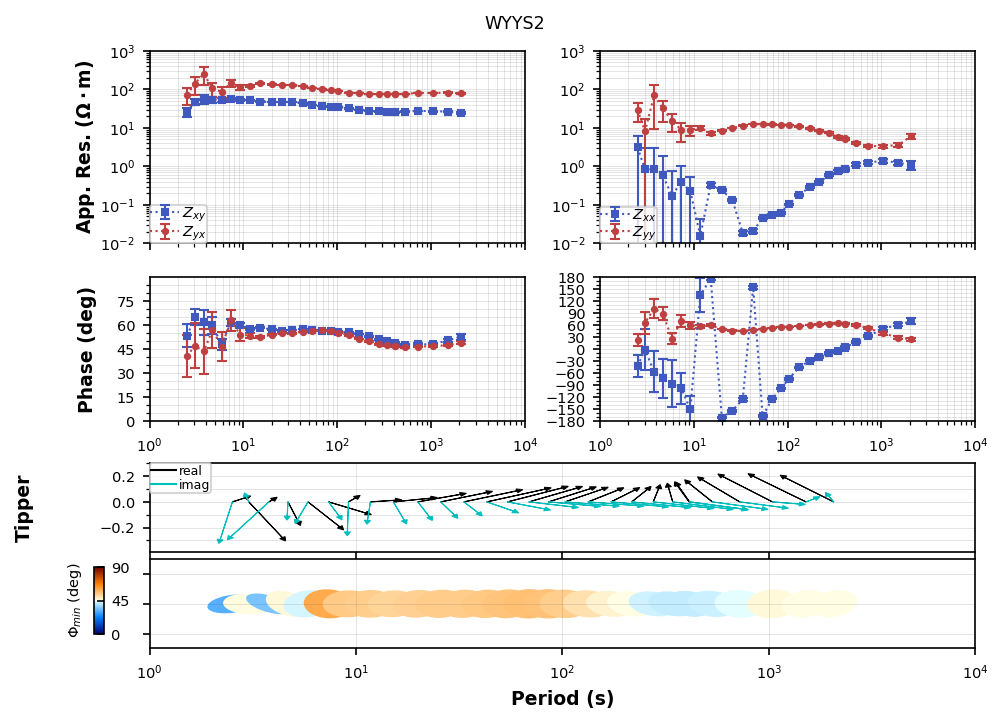

CPU times: user 1min 20s, sys: 1.26 s, total: 1min 21s
Wall time: 45.3 s


In [21]:
%%time
processed_dict = ap.process(
    [1],
    processing_dict=processing_dict,
    save_to_mth5=True,
)
mt_object = processed_dict[1]["tf"]
plot_res_phase = mt_object.plot_mt_response(plot_num=2)

### Write Transfer Function to a File

Here we will write to an EMTF XML format

In [22]:
xml_file_base = f"example_tf.xml"
emtf_obj = mt_object.write(fn=xml_file_base, file_type="emtfxml")

### Plot Phase Tensor

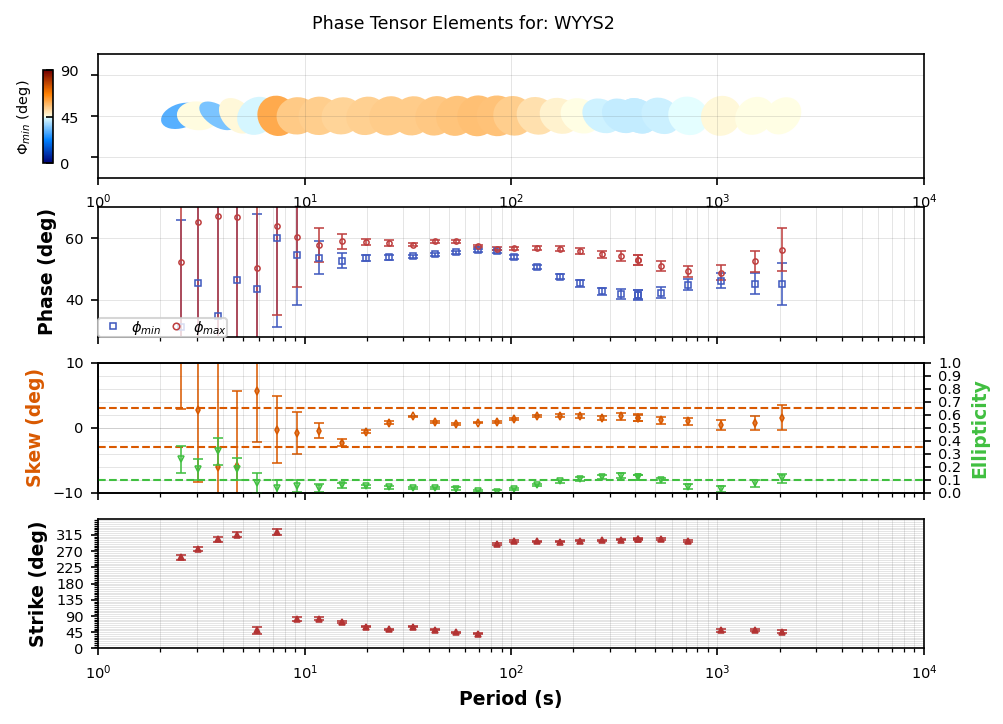

In [23]:
plot_pt = mt_object.plot_phase_tensor(fig_num=6)